# Elastodinámica

Nota: a este documento lo podremos ejecutar de manera dinámica si tienen instalado:

- Python 3.5 o más nuevo instalado.
- [Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html).
- [FEniCS](https://fenicsproject.org/).

La visualización del mismo es óptima utilizando Jupyter Notebook.

### Referencias
- Capítulo 26 de Anders Logg, Kent-Andre Mardal, Garth N. Wells, [Automated Solution of Differential Equations by the Finite Element Method](https://www.springer.com/gp/book/9783642230981). The FEniCS Book (2012), Springer.

- Sacamos varias cosas del sitio de J. Bleyer, [seguir enlace](https://comet-fenics.readthedocs.io/en/latest/).

## Introducción

En esta sección trataremos el problema elastodinámico, es decir, a un sólido se le aplica una fuerza que puede ser variante en el tiempo. Esto hará que se pueda acelerar por la segunda ley de Newton. Entonces se debe aplicar la ecuación de balance de momento. Como ya sabemos, el sólido se acelerará pero ese movimiento deberá amortiguarse, esto se puede modelar de varias formas, aquí comentaremos las siguientes:  

1. Utilizando una **relación constitutiva** (relaciona la tensión $\sigma$ y la deformación $\varepsilon$) que contiene la viscosidad. Comenzaremos por este por su similitud con lo que venimos aprendiendo.
2. Agregando una viscosidad a conocida como **amortiguamiento de Rayleigh**. Este método es el abordaje más comunmente utilizado en estructuras.

Tal como nos pasó en la [sección anterior](https://github.com/rirastorza/Intro2FEM/blob/master/Problemas_dependientes_del_tiempo/Introduccion_problema_termico.ipynb), aparece una derivada, aunque en este caso es la derivada segunda del desplazamiento ($\ddot{u}$), que es nuestra incógnita. Para esto se puede utilizar un método implícito que es incondicionalmente estable: la familia de [**métodos Newmarks o métodos $\alpha$-generalizados**](https://link.springer.com/article/10.1007/s00466-001-0273-z).

### Ecuación de balance de momento
El planteo con el que trabajaremos será el siguiente:

$$ \left \{ \begin{array}{l} \rho \ddot{u}-\nabla\cdot \sigma = b \ \  \text{en} \ \ \Omega\times \text{I} \\ u\left(t\right)=g\text{ en } \ \partial \Omega_{D}\times \text{I} \text{ (condición de borde Dirichlet) } \\ 
\sigma\left(t\right)\cdot n= h\text{ en } \ \partial \Omega_{N}\times \text{I} \text{ (condición de borde Newmann) } \\ 
u\left(x,0\right)=u_{0}\left(x\right) \ \  \text{en} \ \ \Omega \text{ (condición inicial de posición) } \\ 
\dot{u}\left(x,0\right)=v_{0}\left(x\right) \ \  \text{en} \ \ \Omega \text{ (condición inicial de velocidad) } \end{array} \tag{1}\right .$$

La ecuación es similar a la que vimos en la sección de [elasticidad estática](https://github.com/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_2D/ElasticidadLineal2D.ipynb), con la diferencia que aparece el término nuevo $\rho \ddot{u}$ que justamente considera la aceleración por unidad de volumen por eso aparece multiplicada por la densidad $\rho$. A estas fuerzas que aparecen en los nodos del sólido se las denomina fuerzas inerciales (obviamente $u$ es el desplazamiento y $\sigma$ es la tensión). Note que también aparece los dominios $\Omega$ y $\partial \Omega$ multiplicados por $\text{I}$, esta notación se introduce para representar que además existe un recorrido en el tiempo $\text{I}=\left[0,T\right]$, donde $T$ es el tiempo final.

La Ec. (1) relaciona la tensión con el desplazamiento, ahora debemos también relacionarlos con la deformación. Si, según el punto 1) arriba mencionado, consideramos la siguiente relación constitutiva:

$$\sigma = 2\mu\varepsilon+\left(\lambda tr\left(\varepsilon\right)+\eta tr\left(\dot{\varepsilon}\right)\right)I\tag{2}.$$

y a su vez sabemos que $\varepsilon = \frac{1}{2}\left(\nabla u + \nabla u^{T}\right)$ y $\dot{\varepsilon}= \frac{1}{2}\left(\nabla \dot{u} + \nabla \dot{u}^{T}\right)=\frac{1}{2}\left(\nabla v + \nabla v^{T}\right)$, tenemos la relación entre los tres: $\sigma$, $\varepsilon$, y $u$ (también con la velocidad $v$). Además, aquí aparece un **coeficiente de viscosidad ($\eta$)** que tiene en cuenta la fricciones microscópicas del material, también la fricción con el aire de la pieza, entre otras cosas. En realidad lo debemos pensar como aquello que consuma energía para que la pieza se detenga, se amortigüe. Los parámetros $\mu$ y $\lambda$ son los coeficientes de Lamé que ya hemos visto.

### Formulación variacional

Hacemos lo de siempre, multiplicamos por la función de prueba e integramos en el dominio $\Omega$. Vamos a considerar una función de prueba $w$ (para no confundirnos con la velocidad $v$). Obviamente se asume nula ($w=0$) en $\partial \Omega_{D}$.
 
$$\int_{\Omega}\rho \ddot{u} \ w \ dx - \int_{\Omega} \left(\nabla \cdot \sigma\right) \ w \ dx - \int_{\Omega} bw \ dx = 0 \tag{3}$$

Nuevamente ocurre lo de siempre, debemos bajar el órden de la derivada utilizando la fórmula de Green. 

$$\int_{\Omega}\rho \ddot{u} \ w \ dx + \int_{\Omega} \sigma : \underbrace{\nabla w}_{\varepsilon\left(w\right)} \ dx-\int_{\partial\Omega_{N}}\underbrace{h}_{\sigma \cdot n} w \ ds - \int_{\Omega} bw \ dx = 0 \tag{4}$$

### Discretización del tiempo

Hasta ahora no hemos hablado nada sobre la discretización en el tiempo. En este caso aplicaremos la familia de métodos denominados Newmark, que son muy utilizados en dinámica de estructuras. Para esto, tomamos la aproximación de segundo órden del desplazamiento en $n+1$ considerando un paso de tiempo $\Delta t$:

$$u_{n+1}=u_{n}+\Delta t \dot{u}_{n}+\frac{1}{2}\Delta t^{2}\left[2\beta \ddot{u}_{n+1}+\left(1-2\beta\right)\ddot{u}_{n}\right]\tag{4}$$

y de la velocidad

$$\dot{u}_{n+1}= \dot{u}_{n}+\Delta t \left[\gamma \ddot{u}_{n+1}+\left(1-\gamma\right)\ddot{u}_{n}\right]\tag{5}.$$

Aparecen dos parámetros ($\beta$ y $\gamma$) que, dependiendo de cómo sea su elección, será un método **incondicionalmente estable**. Despejamos $\ddot{u}_{n+1}$ de la Ec. (4) y se obtiene:

$$\ddot{u}_{n+1}= \frac{1}{\beta\Delta t^{2}}\left(u_{n+1}-u_{n}-\Delta t \dot{u}_{n}\right)-\left(\frac{1}{2\beta}-1\right)\ddot{u}_{n}\tag{6}$$

y reemplazándola en Ec. (5) se tiene:

$$\dot{u}_{n+1}=\frac{\gamma}{\beta\Delta t}\left(u_{n+1}-u_{n}\right)-\left(\frac{\gamma}{\beta}-1\right)\dot{u}_{n}-\Delta t \left(\frac{\gamma}{2\beta}-1\right)\ddot{u}_{n}$$

si observamos esta última ecuación, nos damos cuenta que lo único que no conocemos es $u_{n+1}$, el resto de las variables corresponden al paso anterior $n$ de la iteración. 

Nota: existe también una generalización de esta familia de métodos, que se denomina métodos $\alpha$-generalizados, de los cuales hablaremos más adelante.


### Barra empotrada en 3D

Como ejemplo de aplicación usaremos la barra empotrada, pero ahora en 3D. 

[<img src="barra3D.png" width="400"/>](barra3D.png)

Las diferencias con el ejemplo anterior de elasticidad estática es que ahora, además de la fuerza peso de la barra, aparece la tensión en la dirección negativa de $z$ en la punta de la barra.

#### Código

Comenzamos como siempre, importando las librerías y definiendo los parámetros, en este caso, mecánicos ($\rho$, $E$, $\nu$ y lo nuevo, la viscosidad $\eta$) y de tiempo ($\Delta t$, $\beta$ y $\gamma$).

In [1]:
from dolfin import *

parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

E = 1000.0
nu = 0.3
mu = E/(2.0*(1.0+nu))
lmbda = E*nu/((1.0+nu)*(1.0-2.0*nu))
#Densidad de masa y coeficiente de viscosidad
rho = 1.0
eta = 500.0

#Parametros de tiempo
beta = 0.25
gamma = 0.5
dt = 0.08
t = 0.0
T = 4.0

Luego definimos las funciones que nos definen los subdominios para las condiciones de borde.

In [2]:
def izquierda(x, on_boundary):
    return near(x[0], 0.) and on_boundary

def derecha(x, on_boundary):
    return near(x[0], 1.) and on_boundary

Ahora creamos una función para la discretización del tiempo que actualiza el desplazamiento, la velocidad y la aceleración según las Ecs. (5) y (6).

In [3]:
def actualiza(u,u0,v0,a0,beta,gamma,dt):
    u_vec,u0_vec = u.vector(),u0.vector()
    v0_vec,a0_vec = v0.vector(),a0.vector()
    
    #Actualizar la aceleración y la velocidad
    a_vec = (1.0/(beta*dt*dt))*(u_vec-u0_vec-v0_vec*dt)-(1.0/(2*beta)-1.0)*a0_vec
    
    v_vec = v0_vec+dt*(gamma*a_vec+(1.0-gamma)*a0_vec)
    
    #Acualiza tn <-- tn+1
    v0.vector()[:],a0.vector()[:] = v_vec,a_vec
    u0.vector()[:] = u.vector()

Luego creamos la malla, y los campos del paso actual y el siguiente.

In [4]:
mesh = BoxMesh(Point(0., 0., 0.), Point(1., 0.1, 0.04), 60, 10, 5)
V = VectorFunctionSpace(mesh, 'Lagrange', degree=1)

u1 = TrialFunction(V)
w = TestFunction(V)

#Campos del el paso previo (desplazamiento, velocidad, aceleración)
u = Function(V)
u0 = Function(V)
v0 = Function(V)
a0 = Function(V)

Noten que aparece tres variables una que es una trial u1, y dos funciones u y u0.

Ahora noten cómo se definen las condiciones de contorno, y por último la tensión aplicada en la parte derecha de la barra como una *Expression*.

In [5]:
boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundary_subdomains.set_all(0)
force_boundary = AutoSubDomain(derecha)
force_boundary.mark(boundary_subdomains, 3)

dss = ds(subdomain_data=boundary_subdomains)

#Condición de borde del costado izquierdo
zero = Constant((0.0, 0.0, 0.0))
bc = DirichletBC(V, zero, izquierda)

#Carga aplicada
p0 = 1.
cutoff_Tc = T/5
#NOTAR COMO SE DEFINE LA FUNCIÓN!
h = Expression(("0", "t <= tc ? p0*t/tc : 0","0"), t=0, tc=cutoff_Tc, p0=p0, degree=0)

Ahora comenzaremos a escribir la formulación variacional, aunque debemos definir: la velocidad (v1) y aceleración (a1) según la discretización en tiempo, $h$ aplicado en el borde derecho (marcado con la etiqueta 3 en el diferencial dss) y la relación constitutiva definida por la Ec. (2). Noten que como el medio es isotrópico y homogéneo se tomó: $\varepsilon = \nabla u$ y $\dot{\varepsilon} = \nabla \dot{u} = \nabla v$.

In [7]:
#Velocidad y aceleración en tn+1
v1=(gamma/(beta*dt))*(u1-u0)-(gamma/beta-1.0)*v0-dt*(gamma/(2.0*beta)-1.0)*a0
a1= (1.0/(beta*dt**2.0))*(u1-u0-dt*v0)-(1.0/(2.0*beta)-1.0)*a0

#Trabajo de fuerzas externas
def Wext(w):
    return dot(w, h)*dss(3)

#Tensor de tensión
def sigma(u,v):
    return 2.0*mu*sym(grad(u))+(lmbda*tr(grad(u))+eta*tr(grad(v)))*Identity(u.geometric_dimension())

Finalmente escribimos la formulación variacional tal como la Ec. (4).

In [8]:
F = (rho*dot(a1,w)+inner(sigma(u1,v1),sym(grad(w))))*dx-Wext(w)
a = lhs(F)
L = rhs(F)

Note que usamos la función dot, que indica el producto escalar. 

Lo que sigue ahora es iterar en todos los pasos de tiempo, guardando en cada paso las variable desplazamiento en un archivo pdv, por ejemplo. También debemos actualizar en cada paso los valores de desplazamiento, velocidad y aceleración con la función que creamos (actualiza).

In [9]:
file = File("data/desplazamiento.pvd")
u_tip = []
while t <=T:
    t += dt
    h.t = t
    print("Time: ", t)
    #problem.solve()
    solve(a == L, u, bc)
    #u = problem.solve()
    u_tip.append(u(1., 0.05, 0.0)[1])
    actualiza(u,u0,v0,a0,beta,gamma,dt)
    file<<u

Time:  0.08
Time:  0.16
Time:  0.24
Time:  0.32
Time:  0.4
Time:  0.48000000000000004
Time:  0.56
Time:  0.64
Time:  0.72
Time:  0.7999999999999999
Time:  0.8799999999999999
Time:  0.9599999999999999
Time:  1.0399999999999998
Time:  1.1199999999999999
Time:  1.2
Time:  1.28
Time:  1.36
Time:  1.4400000000000002
Time:  1.5200000000000002
Time:  1.6000000000000003
Time:  1.6800000000000004
Time:  1.7600000000000005
Time:  1.8400000000000005
Time:  1.9200000000000006
Time:  2.0000000000000004
Time:  2.0800000000000005
Time:  2.1600000000000006
Time:  2.2400000000000007
Time:  2.3200000000000007
Time:  2.400000000000001
Time:  2.480000000000001
Time:  2.560000000000001
Time:  2.640000000000001
Time:  2.720000000000001
Time:  2.800000000000001
Time:  2.8800000000000012
Time:  2.9600000000000013
Time:  3.0400000000000014
Time:  3.1200000000000014
Time:  3.2000000000000015
Time:  3.2800000000000016
Time:  3.3600000000000017
Time:  3.4400000000000017
Time:  3.520000000000002
Time:  3.600000000

Luego podemos también dibujar, por ejemplo, el desplazamiento de la punta de la barra.

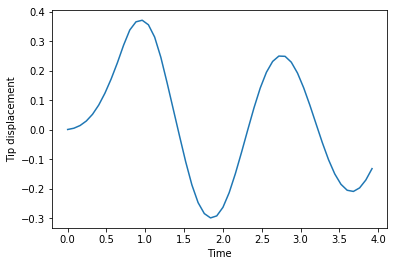

In [11]:
import matplotlib.pyplot as plt
import numpy as np
u_final = np.asarray(u_tip)
tiempo = np.arange(0,dt*(len(u_final)),dt)
plt.figure()
plt.plot(tiempo,u_tip)
plt.xlabel("Time")
plt.ylabel("Tip displacement")
plt.show()